In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from stable_baselines3.common.monitor import Monitor
from collections import Counter

import sys
sys.path.append('../..')
from iai_models import otrl

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
env = Monitor(gym.make("Blackjack-v1", sab=True, render_mode="rgb_array"))

In [3]:
hard_policy = pd.DataFrame(index=range(11, 18), columns=range(1, 11), dtype=int)
soft_policy = pd.DataFrame(index=range(17, 21), columns=range(1, 11), dtype=int)

print(hard_policy)
print(soft_policy)

    1   2   3   4   5   6   7   8   9   10
11 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
17 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
    1   2   3   4   5   6   7   8   9   10
17 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
18 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
19 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN
20 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN


In [4]:
states_rl = pd.read_csv("../../pretrained_models/blackjack/blackjack_states.csv")
outcomes_rl = pd.read_csv("../../pretrained_models/blackjack/blackjack_outcomes.csv")
action_rl = (outcomes_rl.idxmax(axis=1) == outcomes_rl.columns[1]).astype(int)
pretrained_mdl = otrl.EnumeratedPolicy(
    [tuple(items) for items in states_rl.values.tolist()],
    action_rl,
    states_rl.columns,
    outcomes_rl.columns
)

In [5]:
policy_hard = pd.read_csv("../../pretrained_models/blackjack/blackjack_optimal_hard.csv", index_col=0)
policy_soft = pd.read_csv("../../pretrained_models/blackjack/blackjack_optimal_soft.csv", index_col=0)
states_full = []
actions_full = []
for player in policy_hard.index:
    for dealer in policy_hard.columns:
        states_full.append((player, int(dealer), 0))
        actions_full.append(policy_hard.loc[player, dealer])
for player in policy_soft.index:
    for dealer in policy_soft.columns:
        states_full.append((player, int(dealer), 1))
        actions_full.append(policy_soft.loc[player, dealer])
true_mdl = otrl.EnumeratedPolicy(
    states_full,
    actions_full,
    states_rl.columns,
    outcomes_rl.columns
)

In [6]:
models = {
    "OCT": otrl.OTRLPretrained(f"json/oct.json"),
    "OPT": otrl.OTRLPretrained(f"json/opt_shelf.json"),
    "OPCT": otrl.OTRLPretrained(f"json/opt.json"),
    "Pretrained": pretrained_mdl,
    "True": true_mdl
}

hard_policies = {}
soft_policies = {}

for name, mdl in models.items():
    hard_policies[name] = hard_policy.copy()
    soft_policies[name] = soft_policy.copy()

In [7]:
for name, mdl in models.items():
    for player in hard_policies[name].index:
        for dealer in hard_policies[name].columns:
            action = mdl.predict((player, dealer, 0))[0]
            hard_policies[name].loc[player, dealer] = int(action)

for name, mdl in models.items():
    for player in soft_policies[name].index:
        for dealer in soft_policies[name].columns:
            action = mdl.predict((player, dealer, 1))[0]
            soft_policies[name].loc[player, dealer] = int(action)

print(hard_policies["True"])
print(soft_policies["True"])

     1    2    3    4    5    6    7    8    9    10
11  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
12  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
13  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
14  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
15  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
16  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
     1    2    3    4    5    6    7    8    9    10
17  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
18  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [8]:
full_policies = {}
for name, mdl in models.items():
    hardp = hard_policies[name].copy()
    softp = soft_policies[name].copy()

    hardp.index = hardp.index.astype(str)
    softp.index = "A"+ (softp.index - 11).astype(str)

    policy = pd.concat((hardp, softp))

    full_policies[name] = policy

In [9]:
n_episodes = 10_000
rewards = [-1, 0, 1]
reward_df = pd.DataFrame(index=rewards, columns=[name for name in models.keys()])

for name, mdl in models.items():
    ep_reward, ep_lens = mdl.evaluate(env, n_eval_episodes=n_episodes, return_episode_rewards=True)
    counts = Counter(ep_reward)
    for reward in rewards:
        reward_df.loc[reward, name] = counts[reward] / n_episodes

In [10]:
reward_df

,OCT,OPT,OPCT,Pretrained,True
-1,0.4771,0.4904,0.4771,0.4793,0.4763
0,0.0911,0.1042,0.0874,0.0935,0.0905
1,0.4318,0.4054,0.4355,0.4272,0.4332


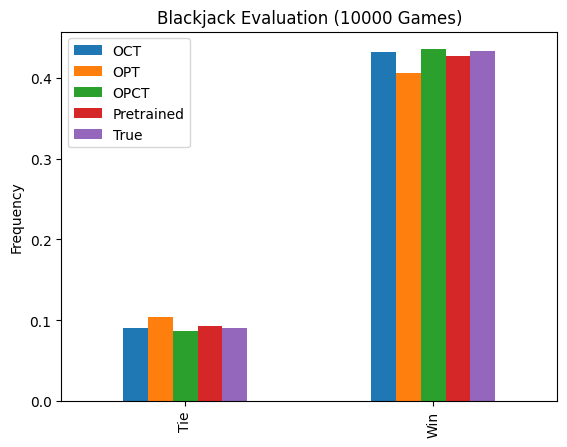

In [19]:
fig, ax = plt.subplots()
reward_df.drop(-1).plot(kind="bar", ax=ax)
ax.set_xticks(range(len(rewards) - 1))
ax.set_xticklabels(["Tie", "Win"])
plt.ylabel("Frequency")
plt.title(f"Blackjack Evaluation ({n_episodes} Games)")
plt.legend()
plt.show()

In [12]:
n_unsolved_states = 10 * 10 * 2 - 1
print(n_unsolved_states)

summary_df = pd.DataFrame(
    index=models.keys(),
    columns=[
        "missed_true",
        "missed_pretrained",
        "accuracy_true",
        "accuracy_pretrained",
        "win_prop",
        "tie_prop",
        "lose_prop",
        "avg_reward"
    ]
)

for name, mdl in models.items():

    summary_df.loc[name, "missed_true"] = np.sum(np.abs(full_policies[name] - full_policies["True"]).to_numpy(int))
    summary_df.loc[name, "missed_pretrained"] = np.sum(np.abs(full_policies[name] - full_policies["Pretrained"]).to_numpy(int))
    summary_df.loc[name, "accuracy_true"] = 1 - summary_df.loc[name, "missed_true"] / n_unsolved_states
    summary_df.loc[name, "accuracy_pretrained"] = 1 - summary_df.loc[name, "missed_pretrained"] / n_unsolved_states
    summary_df.loc[name, "win_prop"] = reward_df.loc[1, name]
    summary_df.loc[name, "tie_prop"] = reward_df.loc[0, name]
    summary_df.loc[name, "lose_prop"] = reward_df.loc[-1, name]
    summary_df.loc[name, "avg_reward"] = summary_df.loc[name, "win_prop"] - summary_df.loc[name, "lose_prop"]


summary_df.loc["Pretrained", "missed_pretrained"] = np.nan
summary_df.loc["Pretrained", "accuracy_pretrained"] = np.nan
summary_df.loc["True", "missed_pretrained"] = np.nan
summary_df.loc["True", "accuracy_pretrained"] = np.nan
summary_df.loc["True", "missed_true"] = np.nan
summary_df.loc["True", "accuracy_true"] = np.nan
print(summary_df)

199
           missed_true missed_pretrained accuracy_true accuracy_pretrained  \
OCT                  6                 2      0.969849             0.98995   
OPT                 36                34      0.819095            0.829146   
OPCT                 5                 3      0.974874            0.984925   
Pretrained           6               NaN      0.969849                 NaN   
True               NaN               NaN           NaN                 NaN   

           win_prop tie_prop lose_prop avg_reward  
OCT          0.4318   0.0911    0.4771    -0.0453  
OPT          0.4054   0.1042    0.4904     -0.085  
OPCT         0.4355   0.0874    0.4771    -0.0416  
Pretrained   0.4272   0.0935    0.4793    -0.0521  
True         0.4332   0.0905    0.4763    -0.0431  


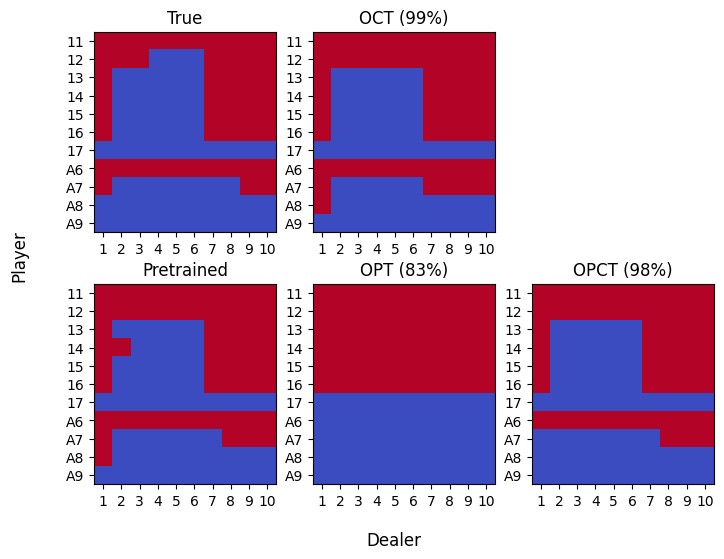

In [13]:
def visualize_policy(mdl_name, title, ax):

    ax.imshow(full_policies[mdl_name], cmap="coolwarm")
    ax.set_xticks(range(len(policy.columns)))
    ax.set_xticklabels(policy.columns)
    ax.set_yticks(range(len(policy.index)))
    ax.set_yticklabels(policy.index)
    ax.set_title(title)

fig, ax = plt.subplots(2, 3, figsize=(8, 6))
visualize_policy("True", "True", ax[0, 0])
visualize_policy("Pretrained", "Pretrained", ax[1, 0])
visualize_policy("OCT", f"OCT ({round(summary_df.loc["OCT", "accuracy_pretrained"] * 100)}%)", ax[0, 1])
visualize_policy("OPT", f"OPT ({round(summary_df.loc["OPT", "accuracy_pretrained"] * 100)}%)", ax[1, 1])
visualize_policy("OPCT", f"OPCT ({round(summary_df.loc["OPCT", "accuracy_pretrained"] * 100)}%)", ax[1, 2])
ax[0, 2].remove()
fig.supxlabel("Dealer")
fig.supylabel("Player")
plt.show()